<a href="https://colab.research.google.com/github/renewable-energy-experiments/carbonfoorprint/blob/master/power_generation_caiso_extrapolated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> US electricity generation by energy source ( price , co2 emission by grids)<center><h1> 
  High granularity Power generation CA ISO ( California) 

# Table of Contents
* [1. DataSet Description](#section-one)
* [2. Import and Preprocessing](#section-two)
* [3. Filler and Filter](#section-three)
* [4. Daily Grpahs](#section-four)
* [5. Carbon Emission vs Fuel](#section-five)
* [6. Price vs Fuel](#section-six)

<a id="section-one"></a>
# 1. DataSet Description

Dataset is weekly reports from EDA  for CA ISO

<a id="section-two"></a>
# 2. Import & Preprocessing

Let's have a first look at the data. For the sake of simplicity we are only looking at data of plant 1 (power generation and weather). Data of power plant 2 can then be explored in a similar manner.

In [3]:
import os
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates 
xformatter = mdates.DateFormatter('%H:%M') # for time axis plots

# import plotly.offline as py
# py.init_notebook_mode(connected=True)

import sklearn
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Import all available data 
# df = pd.read_csv("../input/us-electricity-by-energy-source-in-spring/930-data-export.csv")

df = pd.read_csv("/content/CAISO-supply-20200706.csv")
df2 = pd.read_csv("/content/CAISO-supply-20200707.csv")
df3 = pd.read_csv("/content/CAISO-supply-20200708.csv")
df4 = pd.read_csv("/content/CAISO-supply-20200709.csv")
df5 = pd.read_csv("/content/CAISO-supply-20200710.csv")
df6 = pd.read_csv("/content/CAISO-supply-20200711.csv")

df =  df.transpose()
df2 =  df2.transpose()
df3 =  df3.transpose()
df4 =  df4.transpose()
df5 =  df5.transpose()
df6 =  df6.transpose()

In [5]:
df.rename(columns=df.iloc[0], inplace = True)
df2.rename(columns=df2.iloc[0], inplace = True)
df3.rename(columns=df3.iloc[0], inplace = True)
df4.rename(columns=df4.iloc[0], inplace = True)
df5.rename(columns=df5.iloc[0], inplace = True)
df6.rename(columns=df6.iloc[0], inplace = True)

In [6]:
def df_manipulation(dfs):
    dfs['Timestamp'] = dfs.index
    date =  dfs.iloc[0].Timestamp.replace('Supply ','')
    dfs['DATE'] = date
    dfs = dfs[1:len(dfs)-1]
    dfs['DATE'] =  pd.to_datetime(dfs['DATE'],format = '%m/%d/%Y').dt.date
    dfs['TIME'] = pd.to_datetime(dfs['Timestamp'],format = '%H:%M').dt.time
    dfs['HOURS'] = pd.to_datetime(dfs['TIME'],format='%H:%M:%S').dt.hour
    dfs['MINUTES'] = pd.to_datetime(dfs['TIME'],format='%H:%M:%S').dt.minute
    dfs['MINUTES_PASS'] = dfs['MINUTES'] + dfs['HOURS']*60
    dfs['Timestamp'] = pd.to_datetime(dfs['DATE'].apply(str) +' '+ dfs['TIME'].apply(str), format = '%Y-%m-%d %H:%M:%S')
    return dfs

In [7]:
dff = df_manipulation(df)
dff2 = df_manipulation(df2)
dff3 = df_manipulation(df3)
dff4 = df_manipulation(df4)
dff5 = df_manipulation(df5)
dff6 = df_manipulation(df6)

In [8]:
dff6.tail()

,Renewables,Natural gas,Large hydro,Imports,Batteries,Nuclear,Coal,Other,Timestamp,DATE,TIME,HOURS,MINUTES,MINUTES_PASS
23:35,4927,12518,2188,8925,6,2268,11,0,2020-07-11 23:35:00,2020-07-11,23:35:00,23,35,1415
23:40,4917,12200,2179,9016,1,2267,10,0,2020-07-11 23:40:00,2020-07-11,23:40:00,23,40,1420
23:45,4920,12214,2156,8824,-7,2267,10,0,2020-07-11 23:45:00,2020-07-11,23:45:00,23,45,1425
23:50,4929,12081,2155,8725,-8,2267,9,0,2020-07-11 23:50:00,2020-07-11,23:50:00,23,50,1430
23:55,4952,11803,2145,8635,-10,2267,9,0,2020-07-11 23:55:00,2020-07-11,23:55:00,23,55,1435


In [9]:
# df['Timestamp'] = df.index
# df['DATE'] = df.iloc[0].Timestamp.replace('Supply ','')

In [10]:
# Remove row 0 
# df.drop([1], inplace = True)
# df.columns = df.iloc[0]

# df = df[1:len(df)-1]

In [11]:
# df['DATE'] =  pd.to_datetime(df['DATE'],format = '%m/%d/%Y', errors='coerce').dt.date
# df['TIME'] = pd.to_datetime(df['Timestamp'],format = '%H:%M', errors='coerce').dt.time

In [12]:
# # add hours and minutes for ml models
# df['HOURS'] = pd.to_datetime(df['TIME'],format='%H:%M:%S').dt.hour
# df['MINUTES'] = pd.to_datetime(df['TIME'],format='%H:%M:%S').dt.minute
# df['MINUTES_PASS'] = df['MINUTES'] + df['HOURS']*60

In [13]:
# append all 

df = dff.append(dff)
df = df.append(dff2)
df = df.append(dff3)
df = df.append(dff4)
df = df.append(dff5)
df = df.append(dff6)
len(df) 

2016

In [14]:
# Region = df['Region Code'].head(1).item()
# Region

Region="CA ISO"

<a id="section-three"></a>
## 3. Filter and filler 

In [15]:
print(df.dtypes)

Renewables              object
Natural gas             object
Large hydro             object
Imports                 object
Batteries               object
Nuclear                 object
Coal                    object
Other                   object
Timestamp       datetime64[ns]
DATE                    object
TIME                    object
HOURS                    int64
MINUTES                  int64
MINUTES_PASS             int64
dtype: object


In [16]:
# df['Hydro'] = df['Hydro'] + df ['Large hydro']
# df['NaturalGas'] = df['NaturalGas'] + df ['Natural gas']
df = df.rename(columns={"Natural gas": "NaturalGas",
                        "Renewables" : "Solar",
                        "Large hydro": "Hydro"
                       })
df.head()

,Solar,NaturalGas,Hydro,Imports,Batteries,Nuclear,Coal,Other,Timestamp,DATE,TIME,HOURS,MINUTES,MINUTES_PASS
0:00,6487,6999,1859,7899,-1,2266,9,0,2020-07-06 00:00:00,2020-07-06,00:00:00,0,0,0
0:05,6482,6674,1883,8142,12,2266,11,0,2020-07-06 00:05:00,2020-07-06,00:05:00,0,5,5
0:10,6487,6501,1844,8197,-6,2266,10,0,2020-07-06 00:10:00,2020-07-06,00:10:00,0,10,10
0:15,6466,6588,1852,8037,-31,2266,10,0,2020-07-06 00:15:00,2020-07-06,00:15:00,0,15,15
0:20,6422,6509,1860,8012,-31,2266,10,0,2020-07-06 00:20:00,2020-07-06,00:20:00,0,20,20


## Fill up missing columns as 0 

In [17]:
column_list = ("Wind","Solar","Hydro","Other", 
               "Oil", "NaturalGas","Coal","Nuclear")

for col in column_list:
    if col not in df.columns:
        df[col] = 0

df.head()

,Solar,NaturalGas,Hydro,Imports,Batteries,Nuclear,Coal,Other,Timestamp,DATE,TIME,HOURS,MINUTES,MINUTES_PASS,Wind,Oil
0:00,6487,6999,1859,7899,-1,2266,9,0,2020-07-06 00:00:00,2020-07-06,00:00:00,0,0,0,0,0
0:05,6482,6674,1883,8142,12,2266,11,0,2020-07-06 00:05:00,2020-07-06,00:05:00,0,5,5,0,0
0:10,6487,6501,1844,8197,-6,2266,10,0,2020-07-06 00:10:00,2020-07-06,00:10:00,0,10,10,0,0
0:15,6466,6588,1852,8037,-31,2266,10,0,2020-07-06 00:15:00,2020-07-06,00:15:00,0,15,15,0,0
0:20,6422,6509,1860,8012,-31,2266,10,0,2020-07-06 00:20:00,2020-07-06,00:20:00,0,20,20,0,0


In [18]:
df['Nuclear'] = pd.to_numeric(df['Nuclear'], errors='coerce').fillna(0)
df['Hydro'] = pd.to_numeric(df['Hydro'], errors='coerce').fillna(0)
df['NaturalGas'] = pd.to_numeric(df['NaturalGas'], errors='coerce').fillna(0)
df['Coal'] = pd.to_numeric(df['Coal'], errors='coerce').fillna(0)
df['Solar'] = pd.to_numeric(df['Solar'], errors='coerce').fillna(0)
df['Coal'] = pd.to_numeric(df['Coal'], errors='coerce').fillna(0)
df['Oil'] = pd.to_numeric(df['Oil'], errors='coerce').fillna(0)
df['Other'] = pd.to_numeric(df['Other'], errors='coerce').fillna(0)
print(df.dtypes)

Solar                    int64
NaturalGas               int64
Hydro                    int64
Imports                 object
Batteries               object
Nuclear                  int64
Coal                     int64
Other                    int64
Timestamp       datetime64[ns]
DATE                    object
TIME                    object
HOURS                    int64
MINUTES                  int64
MINUTES_PASS             int64
Wind                     int64
Oil                      int64
dtype: object


## Timestamp  different utility Graphs  

In [19]:
dates = df['DATE'].unique()
dates

array([datetime.date(2020, 7, 6), datetime.date(2020, 7, 7),
       datetime.date(2020, 7, 8), datetime.date(2020, 7, 9),
       datetime.date(2020, 7, 10), datetime.date(2020, 7, 11)],
      dtype=object)

In [20]:
# remove first day which doesnt have all hours 
# dates= dates[1:]

In [21]:
# all the hours in day
day1 = df[df['DATE']==dates[0]]
day1['HOURS'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [22]:
# df['Other'] = df['Other'].astype(int) + df['Wood'].astype(int) + df['Refuse'].astype(int) + df['LandfillGas'].astype(int)
# df = df.drop(columns=['Wood','Refuse','Renewables','LandfillGas'])
# df.head()

### Inperpolate values for missing dates

In [23]:
# index = pd.date_range(datetime.date(2020, 7, 6), periods=1440, freq='T')
# series = pd.Series(range(1440), index=index, name='Timestamp')
# series = pd.to_datetime(series.index,format = '%Y-%d-%m %H:%M:%S')
# # print(series)

# dhours = df[df['DATE']==datetime.date(2020, 7, 6)]
# dunique_minpass = dhours['Timestamp'].unique()
# # dunique_minpass = pd.to_datetime(dunique_minpass ,format = '%Y-%d-%m %H:%M:%S')
# # print(dunique_minpass)

# for m in series: 
#     if m not in dunique_minpass:
#         print("missing tiemstamp ", m)
#         dhours = dhours.append({ 
#             'Timestamp': m,
#             'Renewables': 0
#         }, ignore_index = True) 
#     else :
#         print("Exists tmestamp ", m) 

In [24]:
df.head()

,Solar,NaturalGas,Hydro,Imports,Batteries,Nuclear,Coal,Other,Timestamp,DATE,TIME,HOURS,MINUTES,MINUTES_PASS,Wind,Oil
0:00,6487,6999,1859,7899,-1,2266,9,0,2020-07-06 00:00:00,2020-07-06,00:00:00,0,0,0,0,0
0:05,6482,6674,1883,8142,12,2266,11,0,2020-07-06 00:05:00,2020-07-06,00:05:00,0,5,5,0,0
0:10,6487,6501,1844,8197,-6,2266,10,0,2020-07-06 00:10:00,2020-07-06,00:10:00,0,10,10,0,0
0:15,6466,6588,1852,8037,-31,2266,10,0,2020-07-06 00:15:00,2020-07-06,00:15:00,0,15,15,0,0
0:20,6422,6509,1860,8012,-31,2266,10,0,2020-07-06 00:20:00,2020-07-06,00:20:00,0,20,20,0,0


In [25]:
# index = pd.date_range(datetime.date(2020, 6, 7), periods=1440, freq='T')
# series = pd.Series(range(0,1440,1), index=index, name='Timestamp')
# series = pd.to_datetime(series.index, format = '%Y-%d-%m %H:%M')
# series

In [26]:
df2 = pd.DataFrame()

for d in dates:
    print(d)
    dhours = df[df['DATE']==d]
    dunique_minpass = dhours['Timestamp'].unique()
    dunique_minpass = pd.to_datetime(dunique_minpass )
    # print("List of supplied timestamps ")
    # print(dunique_minpass.unique())

    index = pd.date_range(d, periods=1440, freq='T')
    series = pd.Series(range(0,1440,1), index=index, name='Timestamp')
    series = pd.to_datetime(series.index)
    print(series) 

    for m in series: 
        if m not in dunique_minpass:
            # print("missing tiemstamp " , m)
            dhours = dhours.append({ 
              'Timestamp': m,
              'Batteries': 0
            }, ignore_index = True) 
    
    dhours = dhours.sort_values(by='Timestamp')
    dhours = dhours.interpolate(method ='linear', limit_direction ='forward')

    # adding separate time and date columns
    dhours["DATE"] = pd.to_datetime(dhours["Timestamp"]).dt.date # add new column with date
    dhours["TIME"] = pd.to_datetime(dhours["Timestamp"]).dt.time # add new column with time

    # add hours and minutes for ml models
    dhours['HOURS'] = pd.to_datetime(dhours['TIME'],format='%H:%M:%S').dt.hour
    dhours['MINUTES'] = pd.to_datetime(dhours['TIME'],format='%H:%M:%S').dt.minute
    dhours['MINUTES_PASS'] = dhours['MINUTES'] + dhours['HOURS']*60

    # change index to minute pass 
    dhours = dhours.set_index('MINUTES_PASS')

    # remove duplicates 
    dhours = dhours.drop_duplicates(keep ='first')

    # print(" Now generated unique timestamps")
    # print(dhours['Timestamp'].unique())

    df2 = df2.append(dhours)

len(df2)
df2.head(8)

2020-07-06
DatetimeIndex(['2020-07-06 00:00:00', '2020-07-06 00:01:00',
               '2020-07-06 00:02:00', '2020-07-06 00:03:00',
               '2020-07-06 00:04:00', '2020-07-06 00:05:00',
               '2020-07-06 00:06:00', '2020-07-06 00:07:00',
               '2020-07-06 00:08:00', '2020-07-06 00:09:00',
               ...
               '2020-07-06 23:50:00', '2020-07-06 23:51:00',
               '2020-07-06 23:52:00', '2020-07-06 23:53:00',
               '2020-07-06 23:54:00', '2020-07-06 23:55:00',
               '2020-07-06 23:56:00', '2020-07-06 23:57:00',
               '2020-07-06 23:58:00', '2020-07-06 23:59:00'],
              dtype='datetime64[ns]', length=1440, freq='T')
2020-07-07
DatetimeIndex(['2020-07-07 00:00:00', '2020-07-07 00:01:00',
               '2020-07-07 00:02:00', '2020-07-07 00:03:00',
               '2020-07-07 00:04:00', '2020-07-07 00:05:00',
               '2020-07-07 00:06:00', '2020-07-07 00:07:00',
               '2020-07-07 00:08:00', '2020

,Solar,NaturalGas,Hydro,Imports,Batteries,Nuclear,Coal,Other,Timestamp,DATE,TIME,HOURS,MINUTES,Wind,Oil
MINUTES_PASS,,,,,,,,,,,,,,,
0,6487.0,6999.0,1859.0,7899,-1,2266.0,9.0,0.0,2020-07-06 00:00:00,2020-07-06,00:00:00,0,0,0.0,0.0
1,6486.0,6934.0,1863.8,NaN,0,2266.0,9.4,0.0,2020-07-06 00:01:00,2020-07-06,00:01:00,0,1,0.0,0.0
2,6485.0,6869.0,1868.6,NaN,0,2266.0,9.8,0.0,2020-07-06 00:02:00,2020-07-06,00:02:00,0,2,0.0,0.0
3,6484.0,6804.0,1873.4,NaN,0,2266.0,10.2,0.0,2020-07-06 00:03:00,2020-07-06,00:03:00,0,3,0.0,0.0
4,6483.0,6739.0,1878.2,NaN,0,2266.0,10.6,0.0,2020-07-06 00:04:00,2020-07-06,00:04:00,0,4,0.0,0.0
5,6482.0,6674.0,1883.0,8142,12,2266.0,11.0,0.0,2020-07-06 00:05:00,2020-07-06,00:05:00,0,5,0.0,0.0
6,6483.0,6639.4,1875.2,NaN,0,2266.0,10.8,0.0,2020-07-06 00:06:00,2020-07-06,00:06:00,0,6,0.0,0.0
7,6484.0,6604.8,1867.4,NaN,0,2266.0,10.6,0.0,2020-07-06 00:07:00,2020-07-06,00:07:00,0,7,0.0,0.0


In [27]:
df_backwards = pd.DataFrame()

for d in dates:
    print(d)
    dhours = df[df['DATE']==d]
    dunique_minpass = dhours['Timestamp'].unique()
    dunique_minpass = pd.to_datetime(dunique_minpass )

    index = pd.date_range(d, periods=1440, freq='T')
    series = pd.Series(range(0,1440,1), index=index, name='Timestamp')
    series = pd.to_datetime(series.index)

    for m in series: 
        if m not in dunique_minpass:
            dhours = dhours.append({ 
                'Timestamp': m,
                'Batteries': 0
            }, ignore_index = True) 

    dhours = dhours.sort_values(by='Timestamp')
    dhours = dhours.interpolate(method ='pad', limit_direction ='forward')

    # adding separate time and date columns
    dhours["DATE"] = pd.to_datetime(dhours["Timestamp"]).dt.date # add new column with date
    dhours["TIME"] = pd.to_datetime(dhours["Timestamp"]).dt.time # add new column with time

    # add hours and minutes for ml models
    dhours['HOURS'] = pd.to_datetime(dhours['TIME'],format='%H:%M:%S').dt.hour
    dhours['MINUTES'] = pd.to_datetime(dhours['TIME'],format='%H:%M:%S').dt.minute
    dhours['MINUTES_PASS'] = dhours['MINUTES'] + dhours['HOURS']*60

    # change index to minute pass 
    dhours = dhours.set_index('MINUTES_PASS')

    # remove duplicates 
    dhours = dhours.drop_duplicates(keep ='first')

    df_backwards = df_backwards.append(dhours)

len(df_backwards)
df_backwards.head(8)

2020-07-06
2020-07-07
2020-07-08
2020-07-09
2020-07-10
2020-07-11


,Solar,NaturalGas,Hydro,Imports,Batteries,Nuclear,Coal,Other,Timestamp,DATE,TIME,HOURS,MINUTES,Wind,Oil
MINUTES_PASS,,,,,,,,,,,,,,,
0,6487.0,6999.0,1859.0,7899,-1,2266.0,9.0,0.0,2020-07-06 00:00:00,2020-07-06,00:00:00,0,0,0.0,0.0
1,6487.0,6999.0,1859.0,7899,0,2266.0,9.0,0.0,2020-07-06 00:01:00,2020-07-06,00:01:00,0,1,0.0,0.0
2,6487.0,6999.0,1859.0,7899,0,2266.0,9.0,0.0,2020-07-06 00:02:00,2020-07-06,00:02:00,0,2,0.0,0.0
3,6487.0,6999.0,1859.0,7899,0,2266.0,9.0,0.0,2020-07-06 00:03:00,2020-07-06,00:03:00,0,3,0.0,0.0
4,6487.0,6999.0,1859.0,7899,0,2266.0,9.0,0.0,2020-07-06 00:04:00,2020-07-06,00:04:00,0,4,0.0,0.0
5,6482.0,6674.0,1883.0,8142,12,2266.0,11.0,0.0,2020-07-06 00:05:00,2020-07-06,00:05:00,0,5,0.0,0.0
6,6482.0,6674.0,1883.0,8142,0,2266.0,11.0,0.0,2020-07-06 00:06:00,2020-07-06,00:06:00,0,6,0.0,0.0
7,6482.0,6674.0,1883.0,8142,0,2266.0,11.0,0.0,2020-07-06 00:07:00,2020-07-06,00:07:00,0,7,0.0,0.0


In [28]:
df = df.replace('undefined', 0)
df = df.fillna(0)
df = df.replace(np.nan, 0)
# drop Imports and Batteries 
df.drop(['Imports','Batteries'], axis=1, inplace=True)  
df.head(15)


df2 = df2.replace('undefined', 0)
df2 = df2.fillna(0)
df2 = df2.replace(np.nan, 0)
# drop Imports and Batteries 
df2.drop(['Imports','Batteries'], axis=1, inplace=True)  


df_backwards = df_backwards.replace('undefined', 0)
df_backwards = df_backwards.fillna(0)
df_backwards = df_backwards.replace(np.nan, 0)
# drop Imports and Batteries 
df_backwards.drop(['Imports','Batteries'], axis=1, inplace=True)  

In [29]:
df["total_generation"] = df["Wind"] + df["Solar"] + df["Hydro"] + df["Other"] + df["Oil"] + df["NaturalGas"] + df["Coal"] + df["Nuclear"]
df[["TIME","total_generation"]]

df2["total_generation"] = df2["Wind"] + df2["Solar"] + df2["Hydro"] + df2["Other"] + df2["Oil"] + df2["NaturalGas"] + df2["Coal"] + df2["Nuclear"]
df2[["TIME","total_generation"]]

df_backwards["total_generation"] = df_backwards["Wind"] + df_backwards["Solar"] + df_backwards["Hydro"] + df_backwards["Other"] + df_backwards["Oil"] + df_backwards["NaturalGas"] + df_backwards["Coal"] + df_backwards["Nuclear"]
df_backwards[["TIME","total_generation"]]

,TIME,total_generation
MINUTES_PASS,,
0,00:00:00,17620.0
1,00:01:00,17620.0
2,00:02:00,17620.0
3,00:03:00,17620.0
4,00:04:00,17620.0
...,...,...
1435,23:55:00,21176.0
1436,23:56:00,21176.0
1437,23:57:00,21176.0


Add unix timestamp

In [30]:
df_unix = pd.to_datetime(df["Timestamp"],origin='unix')
df["Timestamp (Unix)"] = (df_unix - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
df["Timestamp (Unix)"].head()

0:00    1593993600
0:05    1593993900
0:10    1593994200
0:15    1593994500
0:20    1593994800
Name: Timestamp (Unix), dtype: int64

### output csv 

CSV outPut total_generation(MW) and total_generation(W) and 
one Timestamp (Unix) and total_generation(W)

In [31]:
# ot = df
# ot['total_generation(W)'] = ot['total_generation']*1000000
# ot.to_csv(Region+'.csv',index=False, header=True)
# ot.to_csv(Region+'_genunix.csv', columns=['Timestamp (Unix)','total_generation(W)'], index=False, header=True)

Output date wise

In [32]:
# for d in dates:
#     print(d)
#     # all the hours in day
#     ot2 = df[df['DATE']==d]
#     ot2.to_csv(Region+"_"+str(d)+'.csv',index=False, header=True)
#     ot2.to_csv(Region+'_genunix_'+str(d)+'.csv', columns=['Timestamp (Unix)','total_generation(W)'],index=False, header=True)

<a id="section-four"></a>
# 4.  Daily graphs

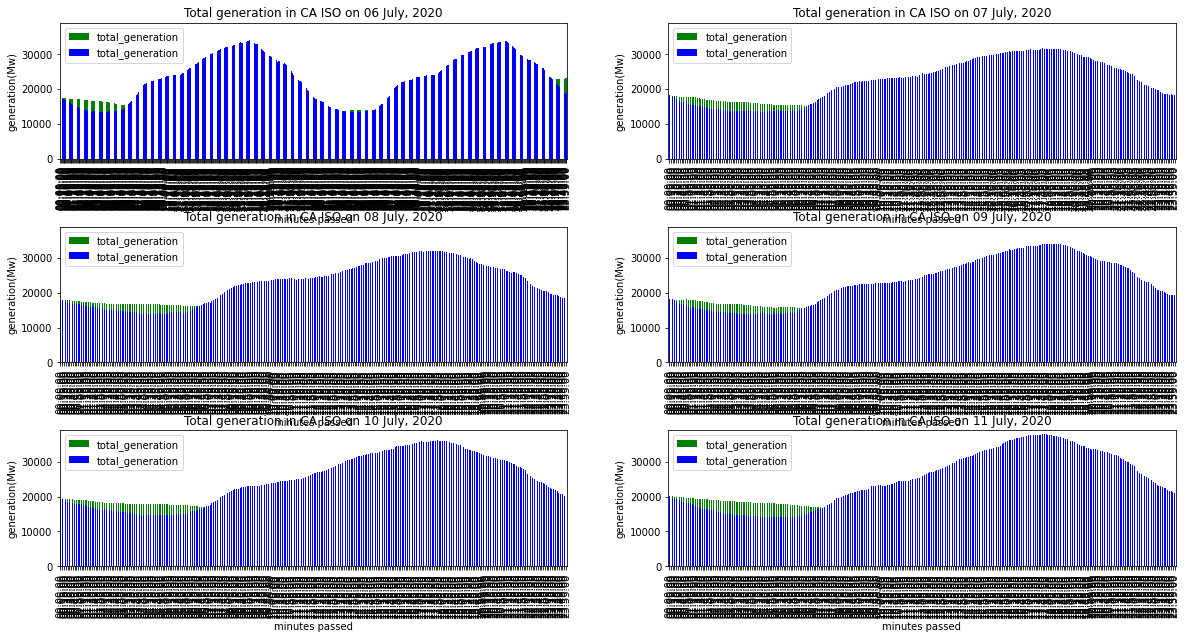

<Figure size 432x288 with 0 Axes>

In [35]:
fig, axs = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(20, 10)
fig.subplots_adjust(wspace=0.2)
fig.subplots_adjust(hspace=0.5)

fig = plt.figure()

for pp,ax in zip(dates, axs.flatten()):

  df2[df2['DATE']==pp].plot.bar(  x="TIME", y=["total_generation"], ax = ax, color="Green")
  df[df['DATE']==pp].plot.bar( x="TIME", y=["total_generation"], ax = ax, color="Blue")
  
  # for frame in [ df,df2]:
  #   sub_df = frame[frame['DATE']==pp]
  #   ax.plot(sub_df['total_generation'])

  ax.set_title("Total generation in "+ Region + " on "+ pp.strftime('%d %B, %Y'))
  ax.set_ylabel("generation(Mw)")
  ax.set_xlabel("minutes passed")
  ax.set_ylim(bottom = 0,top=39000)

    # plt.xlim(0,18000)
    # plt.ylim(0,30)
    # plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(20, 10)
fig.subplots_adjust(wspace=0.2)
fig.subplots_adjust(hspace=0.5)

fig = plt.figure()

for pp,ax in zip(dates, axs.flatten()):

  df[df['DATE']==pp].plot(x='TIME', y=["total_generation"], ax = ax, color="Blue")
  df_backwards[df_backwards['DATE']==pp].plot(x='TIME', y=["total_generation"], ax = ax, color="Brown")
  # for frame in [ df,df2]:
  #   sub_df = frame[frame['DATE']==pp]
  #   ax.plot(sub_df['total_generation'])
 
  mean_gen = round(sub_df["total_generation"].mean())
  max_gen = sub_df["total_generation"].max()
  maxh = sub_df.loc[sub_df["total_generation"]== max_gen]
  maxh = maxh["HOURS"]
  ax.axhline(y=mean_gen, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
  ax.text(5,mean_gen+1000, "Mean " + str(mean_gen) + "(MWh)" )

  ax.set_title("Total generation in "+ Region + " on "+ pp.strftime('%d %B, %Y'))
  ax.set_ylabel("generation(Mw)")
  ax.set_xlabel("minutes passed")
  ax.set_ylim(bottom = 0,top=39000)

In [ ]:
df_backwards.head(15)

In [ ]:
# chats of all days in series 

# for pp in df_nw['DATE'].unique():
# #     print(df_nw[pp])
#     print(pp)
#     sub_df=df_nw[df_nw['DATE']==pp]
#     ax = sub_df.plot(x='HOURS', y=["total_generation"], title = "Total generation in "+ Region + " on "+ pp.strftime('%B %d, %Y'))
#     ax.axhline(y=sub_df["total_generation"].mean(), xmin=-1, xmax=1, color='r', linestyle='--', lw=2)

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(20, 10)
fig.subplots_adjust(wspace=0.2)
fig.subplots_adjust(hspace=0.5)

for pp,ax in zip(dates,axs.flatten()):
#     print(df_nw[pp])
    print(pp)
    sub_df=df[df['DATE']==pp]
    sub_df.plot(x='HOURS', y=["total_generation"],ax = ax, title = "Total generation in "+ Region + " on "+ pp.strftime('%B %d, %Y'))
    
    ax.set_ylabel("generation(Mw)")
    
    mean_gen = round(sub_df["total_generation"].mean())
    max_gen = sub_df["total_generation"].max()
    maxh = sub_df.loc[sub_df["total_generation"]== max_gen]
    maxh = maxh["HOURS"]
    ax.axhline(y=mean_gen, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
    
    ax.text(5,mean_gen+1000, "Mean " + str(mean_gen) + "(MWh)" )
    
    ax.get_legend().remove()
    
#     ax.annotate('Peak '+ str(max_gen)+ "(MWh)", xy=(maxh,max_gen), xytext=(maxh+1, max_gen+1000),
#              arrowprops=dict(arrowstyle='-|>') ,ha='left', rotation=0)
    
    ax.set_ylim(bottom = 0,top=37000)

# ax.axhline(y=df_nw["total_generation"].median(), xmin=-1, xmax=1, color='g', linestyle='--', lw=2)

## Daily chart for the week 

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(20, 10)
fig.subplots_adjust(wspace=0.2)
fig.subplots_adjust(hspace=0.5)

fig.legend(column_list)

    
for pp,ax in zip(dates,axs.flatten()):
#     print(df_nw[pp])
    print(pp)
    sub_df = df[df['DATE']==pp]
    sub_df.plot.line(x='MINUTES_PASS', y = column_list[0], ax = ax, title = "Fuel Mix for generation in "+ Region + " on "+ pp.strftime('%B %d, %Y'),legend=False)
    sub_df.plot.line(x='MINUTES_PASS', y = column_list[1], ax = ax,legend=False)
    sub_df.plot.line(x='MINUTES_PASS', y = column_list[2], ax = ax,legend=False)    
    sub_df.plot.line(x='MINUTES_PASS', y = column_list[3], ax = ax,legend=False)
    sub_df.plot.line(x='MINUTES_PASS', y = column_list[4], ax = ax,legend=False)
    sub_df.plot.line(x='MINUTES_PASS', y = column_list[5], ax = ax,legend=False)
    sub_df.plot.line(x='MINUTES_PASS', y = column_list[6], ax = ax,legend=False)
    sub_df.plot.line(x='MINUTES_PASS', y = column_list[7], ax = ax,legend=False)
    sub_df.plot.line(x='MINUTES_PASS', y =['total_generation'], ax = ax,legend=False)
    
    ax.set_ylabel("generation(Mw)")
    
    mean_gen = round(sub_df["total_generation"].mean())
    max_gen = sub_df["total_generation"].max()
    maxh = sub_df.loc[sub_df["total_generation"]== max_gen]
    maxh = maxh["MINUTES_PASS"]
    ax.axhline(y=mean_gen, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
    
    ax.text(5,mean_gen+1000, "Mean " + str(mean_gen) + "(MW)" )

#     ax.get_legend().remove()
    
#     ax.annotate('Peak '+ str(max_gen)+ "(MWh)", xy=(maxh,max_gen), xytext=(maxh+1, max_gen+1000),
#              arrowprops=dict(arrowstyle='-|>') ,ha='left', rotation=0)
    
    ax.set_ylim(bottom = 0,top=39000)
    
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [ ]:
# # Line Chart ( Trend during the day)
# plt = df.plot.line(x='HOURS',
#                     y = column_list,
#                     title = "Generation in "+ Region + " on "+ Date)
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [ ]:
# usage in one day 
# df_nw.plot(x='HOURS',  kind='hist')

# df_nw.plot(x='HOURS', y=["Wind Generation (MWh)","Solar Generation (MWh)","Hydro Generation (MWh)","Other Generation (MWh)", 
#                         "Petroleum Generation (MWh)", "Natural gas Generation (MWh)","Coal Generation (MWh)","Nuclear Generation (MWh)"], kind='hist')

## Peak Hour

In [ ]:
## Peak Min
peakmin = df[df["total_generation"] == df["total_generation"].max()]
peakmin = peakmin.reset_index(drop=True)
peakmin

In [ ]:
## Peak Hour
# df_nw= df_nw[df_nw["DATE"].astype(str) == Date]
peakhour = df[(df['HOURS'].values==peakmin.HOURS.values) & (df["DATE"].values==peakmin.DATE.values) ]
peakhour

In [ ]:
## Average generation 
average = peakhour["total_generation"].mean()
average

In [ ]:
peakhour.plot(y = ['Wind', 'Solar', 'Hydro', 'Other', 'Oil', 'NaturalGas', 'Coal'])
ax.hlines(23, -.5,.5, linestyles='dashed')
ax.annotate('average',(-0.4, average))

pick value in order off release fromm peakhour

In [ ]:
# peakhour =  peakhour.iloc[: , column_list].copy()  
peakt= peakmin[['Wind', 'Solar', 'Hydro', 'Other', 'Oil', 'NaturalGas', 'Coal', 'Nuclear']].transpose()

# # peakhourt=peakhour2.reindex(["Nuclear Generation (MW)", "Wind Generation (MW)", "Solar Generation (MW)","Hydro Generation (MW)" ,  
# #                          "Coal Generation (MW)", "Natural gas Generation (MW)","Petroleum Generation (MW)","Other Generation (MW)"])

for col in peakt.columns:
    peakt = peakt.rename(columns={col:'generation'})
    
peakt

In [ ]:
# pie chart Percentage for Contribution by fuel during peak hour
peakt["percent"] = (peakt['generation'] / peakt['generation'].sum()) * 100
peakt["percent"] = peakt["percent"].round(1)

# peakt = peakt.mask(peakhour2< 0, 0)
peakt

In [ ]:
peakt["generation"].plot.bar(stacked=True)

In [ ]:
pie_peakhour= peakt.plot.pie(y='percent',title="Fuel Mix in "+ Region + " on "+ str(peakmin.DATE.values[0])+" "+str(peakmin.Timestamp.values[0]) , figsize=(5, 5))
pie_peakhour.legend(bbox_to_anchor=(1,1), loc="centre right")

In [ ]:
peakt = peakt.drop(columns='percent')

In [ ]:
# Cummulative_generation
# peakt['Cummulative_generation']  = peakt["generation"].cumsum()
# peakt

In [ ]:
# peakt.plot(x="Cummulative_generation")

In [ ]:
# draw graph for cummultaive consumption 
# peakhour2.plot("Cummulative_consumption")

# peakhour2.plot.bar(peakhour2["Cummulative_consumption"], drawstyle='steps')
# peakhour2.reset_index().plot.line(peakhour2["Cummulative_consumption"], peakhour2.index, drawstyle='steps')